In [58]:
from google.colab import drive
import os
drive.mount('/content/drive')

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Change the current working directory to MyDrive/DLPJ
os.chdir('/content/drive/MyDrive/DLPJ/src')

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://download.pytorch.org/whl/cu118
Current working directory: /content/drive/MyDrive/DLPJ/src


In [59]:
import time
import numpy as np
import torch

from msstud_spiel_shim import MsStudSpielGame
from msstud_kisenwether_strategy import kisenwether_policy
from qlearning_tabular import TabularQAgent
from dqn_agent import DQNAgent
from dueling_dqn_agent import DuelingDQNAgent
from distributional_dqn_agent import DistributionalDQNAgent
from ppo_agent import PPOAgent
from gpu_utils import get_device

# Let It Ride env
from letitride_env import LetItRideEnv

device = get_device()
print("Using device:", device)

os.makedirs("weights_ms", exist_ok=True)
os.makedirs("weights_lir", exist_ok=True)


Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB
Using device: cuda


In [60]:
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional

# We want the same obs length as MsStudSpielState: 4 (round one-hot) + 13 (ranks) + 4 (suits) = 21

class LetItRideSpielGame:
    def __init__(self, ante: int = 1, seed: Optional[int] = None):
        self._ante = ante
        self._seed = seed
        self._rng = random.Random(seed)

    def new_initial_state(self):
        hand_seed = self._rng.randint(0, 2**32 - 1)
        return LetItRideSpielState(self._ante, hand_seed)

    def num_players(self) -> int:
        return 1

    def __str__(self):
        return f"LetItRideSpielGame(ante={self._ante})"


@dataclass
class LetItRideSpielState:
    ante: int = 1
    seed: Optional[int] = None

    def __post_init__(self):
        # Underlying env
        self._env = LetItRideEnv(ante=self.ante, seed=self.seed)
        self._state = self._env.reset()
        self._player = 0
        self._is_chance = False

    # ---- Core OpenSpiel-like API ----
    def current_player(self) -> int:
        if self.is_terminal():
            return -2
        return self._player

    def is_chance_node(self) -> bool:
        return self._is_chance

    def chance_outcomes(self) -> List[Tuple[int, float]]:
        return []

    def legal_actions(self, player: Optional[int] = None) -> List[int]:
        if self.is_terminal():
            return []
        return self._env.legal_actions()

    def apply_action(self, action: int) -> None:
        if self.is_terminal():
            return
        self._state = self._env.step(action)

    def child(self, action: int) -> "LetItRideSpielState":
        import copy
        nxt = copy.deepcopy(self)
        nxt.apply_action(action)
        return nxt

    # ---- Episode status & return ----
    def is_terminal(self) -> bool:
        return self._state.terminal

    def returns(self) -> List[float]:
        return [self._state.last_reward if self.is_terminal() else 0.0]

    # ---- Observations / info ----
    def observation_string(self, player: int = 0) -> str:
        o = self._env.observation()
        hole = "-".join(sorted(o["hole"]))
        comm = "-".join(sorted(o["community"]))
        bets = ",".join("1" if b else "0" for b in o["active_bets"])
        return f"r{o['round']}|h:{hole}|c:{comm}|b:{bets}"

    def information_state_string(self, player: int = 0) -> str:
        return self.observation_string(player)

    def observation_tensor(self, player: int = 0) -> List[float]:
        """
        Mirror MsStudSpielState.observation_tensor structure:
        - round one-hot (4)
        - ranks histogram (13)
        - suits histogram (4)
        Total = 21, matching the Mississippi Stud models.
        """
        o = self._env.observation()
        rnd = [0.0] * 4
        rnd[o["round"]] = 1.0

        ranks = [0.0] * 13
        suits = {"C": 0.0, "D": 0.0, "H": 0.0, "S": 0.0}

        def rank_int(cs):
            r = cs[0]
            return "23456789TJQKA".index(r)

        # Only use visible cards (hole + revealed community) like MsStud
        for cs in o["hole"] + o["community"]:
            ranks[rank_int(cs)] += 1.0
            suits[cs[1]] += 1.0

        return rnd + ranks + [suits["C"], suits["D"], suits["H"], suits["S"]]

    # ---- Debug helper ----
    def history_str(self) -> str:
        o = self._env.observation()
        return (
            f"round={o['round']} | hole={o['hole']} | comm={o['community']} "
            f"| active_bets={o['active_bets']} | terminal={o['terminal']} "
            f"| last_reward={o['last_reward']}"
        )


In [61]:
def run_policy_ms(game, policy_fn, num_hands=10000):
    """
    Reimplementation of run_policy() from analysis_compare_models_colab,
    specific to Mississippi Stud, including bet accounting and unique-hand tracking.
    """
    returns = []
    total_bet = 0.0
    hands_seen = set()

    for _ in range(num_hands):
        state = game.new_initial_state()

        # Unique hand identification (5 cards)
        o = state._env.observation()
        full_hand = o["hole"] + o["community"]
        # Include friends if you ever set friends > 0
        full_hand += o.get("friends_cards", [])
        hand_tuple = tuple(sorted(full_hand))
        hands_seen.add(hand_tuple)

        hand_bet = 1.0  # ante
        while not state.is_terminal():
            action = policy_fn(state)
            if action in [1, 2, 3]:
                hand_bet += action
            state.apply_action(action)

        returns.append(state.returns()[0])
        total_bet += hand_bet

    avg_ev = np.mean(returns)
    house_edge = -avg_ev / 1.0 * 100.0
    avg_bet = total_bet / num_hands
    element_of_risk = house_edge / avg_bet
    unique_hands = len(hands_seen)
    std_dev = float(np.std(returns))
    return avg_ev, house_edge, avg_bet, element_of_risk, unique_hands, std_dev


def run_policy_lir(game, policy_fn, num_hands=10000):
    """
    Let It Ride evaluation:
    - EV per hand (net profit)
    - House edge (% of ante)
    - Average total wager actually left in action (sum(active_bets)*ante)
    - Element of risk = house_edge / avg_bet
    - Unique hands (5 cards)
    """
    returns = []
    total_bet = 0.0
    hands_seen = set()

    for _ in range(num_hands):
        state = game.new_initial_state()

        # Unique 5-card hand (hole + both community cards, including hidden)
        o0 = state._env.observation()
        # At this point only hole is visible; we need final cards for uniqueness.
        # So we temporarily peek at env.state for cards; this is purely for stats.
        # After reset, LetItRideEnv has .state.hidden_community with 2 cards.
        hidden = state._env.state.hidden_community
        full_hand = o0["hole"] + hidden
        hand_tuple = tuple(sorted(full_hand))
        hands_seen.add(hand_tuple)

        # Play hand
        while not state.is_terminal():
            action = policy_fn(state)
            state.apply_action(action)

        returns.append(state.returns()[0])

        of = state._env.observation()
        # active_bets is a boolean list of length 3
        hand_bet = sum(of["active_bets"]) * state.ante
        total_bet += hand_bet

    avg_ev = np.mean(returns)
    house_edge = -avg_ev / 1.0 * 100.0  # percent of ante
    avg_bet = total_bet / num_hands
    element_of_risk = house_edge / avg_bet if avg_bet > 0 else 0.0
    unique_hands = len(hands_seen)
    std_dev = float(np.std(returns))
    return avg_ev, house_edge, avg_bet, element_of_risk, unique_hands, std_dev



In [62]:
def analyze_model_generic(
    name,
    agent,
    make_game_fn,
    run_policy_fn,
    train_args,
    eval_policy_fn=None,
    eval_hands=10000,
):
    print(f"\n=== {name} ===")
    start = time.time()
    if hasattr(agent, "train") and train_args is not None:
        print(f"Training with {train_args.get('episodes', 'N/A')} episodes...")
        agent.train(**train_args)
    train_time = time.time() - start

    if eval_policy_fn is None:
        eval_policy_fn = agent.policy

    game = make_game_fn()
    metrics = run_policy_fn(game, eval_policy_fn, num_hands=eval_hands)
    print(f"Train time: {train_time:.2f}s")
    print(f"Average EV per hand: {metrics[0]:.5f}")
    print(f"House edge (percent of ante): {metrics[1]:.2f}%")
    print(f"Average bet per hand: {metrics[2]:.2f}")
    print(f"Element of risk: {metrics[3]:.2f}%")
    print(f"Unique hands dealt: {metrics[4]}/{eval_hands}")
    return train_time, metrics


### Mississippi Stud Training

In [63]:
episodes_ms = 200000  # or whatever you’re using

def train_ms_baselines_and_save():
    results = {}

    # Factory for fresh MS Stud game
    make_ms_game = lambda: MsStudSpielGame(ante=1, seed=None, friends=0)

    # 1) Kisenwether baseline (no training)
    print("\n=== Kisenwether Strategy ===")
    k_metrics = run_policy_ms(make_ms_game(), kisenwether_policy, num_hands=10000)
    print(f"Average EV per hand: {k_metrics[0]:.5f}")
    print(f"House edge (percent of ante): {k_metrics[1]:.2f}%")
    print(f"Average bet per hand: {k_metrics[2]:.2f}")
    print(f"Element of risk: {k_metrics[3]:.2f}%")
    print(f"Unique hands dealt: {k_metrics[4]}/10000")
    results["kisenwether"] = k_metrics

    # 2) Tabular Q-learning
    ms_game_for_tab = MsStudSpielGame(ante=1, seed=None, friends=0)
    tab_agent = TabularQAgent(
        ms_game_for_tab,
        alpha=0.2,
        gamma=0.95,
        epsilon=0.9,
        min_epsilon=0.005,
        epsilon_decay=0.9999,
    )
    _, metrics = analyze_model_generic(
        "Tabular Q-Learning (MS)",
        tab_agent,
        make_ms_game,
        run_policy_ms,
        train_args={"episodes": episodes_ms},
    )
    results["tabular_ms"] = metrics

    # 3) DQN (low-lr)
    ms_game_for_dqn = MsStudSpielGame(ante=1, seed=None, friends=0)
    dqn_agent = DQNAgent(
        ms_game_for_dqn,
        lr=1e-4,
        gamma=1.0,
        epsilon=0.95,
        min_epsilon=0.005,
        epsilon_decay=0.9999,
        batch_size=128,
        double_dqn=True,
    )
    _, metrics = analyze_model_generic(
        "DQN (MS, low lr)",
        dqn_agent,
        make_ms_game,
        run_policy_ms,
        train_args={"episodes": episodes_ms},
    )
    torch.save(dqn_agent.model.state_dict(), "weights_ms/dqn_ms_lowlr.pth")
    results["dqn_ms"] = metrics

    # 4) Dueling DQN (low-lr)
    ms_game_for_duel = MsStudSpielGame(ante=1, seed=None, friends=0)
    dueling_agent = DuelingDQNAgent(
        ms_game_for_duel,
        lr=1e-4,
        gamma=1.0,
        epsilon=0.95,
        min_epsilon=0.005,
        epsilon_decay=0.9999,
        batch_size=128,
        double_dqn=True,
    )
    _, metrics = analyze_model_generic(
        "Dueling DQN (MS, low lr)",
        dueling_agent,
        make_ms_game,
        run_policy_ms,
        train_args={"episodes": episodes_ms},
    )
    torch.save(dueling_agent.model.state_dict(), "weights_ms/dueling_ms_lowlr.pth")
    results["dueling_ms"] = metrics

    # 5) Distributional DQN (low-lr)
    ms_game_for_dist = MsStudSpielGame(ante=1, seed=None, friends=0)
    dist_agent = DistributionalDQNAgent(
        ms_game_for_dist,
        lr=1e-4,
        gamma=0.99,
        epsilon=0.95,
        min_epsilon=0.005,
        epsilon_decay=0.9999,
        batch_size=128,
        atom_size=51,
        v_min=-10,
        v_max=10,
    )
    _, metrics = analyze_model_generic(
        "Distributional DQN (MS, low lr)",
        dist_agent,
        make_ms_game,
        run_policy_ms,
        train_args={"episodes": episodes_ms},
    )
    torch.save(dist_agent.model.state_dict(), "weights_ms/distdqn_ms_lowlr.pth")
    results["distdqn_ms"] = metrics

    # 6) PPO (low-lr style)
    ms_game_for_ppo = MsStudSpielGame(ante=1, seed=None, friends=0)
    ppo_agent = PPOAgent(
        ms_game_for_ppo,
        lr=1e-4,
        gamma=1.0,
        clip=0.2,
        batch_size=128,
    )
    _, metrics = analyze_model_generic(
        "PPO (MS, low lr)",
        ppo_agent,
        make_ms_game,
        run_policy_ms,
        train_args={"episodes": episodes_ms},
    )
    torch.save(ppo_agent.model.state_dict(), "weights_ms/ppo_ms_lowlr.pth")
    results["ppo_ms"] = metrics

    return results

ms_results = train_ms_baselines_and_save()
print("MS Training complete. Saved weights in weights_ms/.")


=== Kisenwether Strategy ===
Average EV per hand: -0.03220
House edge (percent of ante): 3.22%
Average bet per hand: 3.59
Element of risk: 0.90%
Unique hands dealt: 1326/10000

=== Tabular Q-Learning (MS) ===
Training with 200000 episodes...
Training tabular Q-learning for 200000 episodes...
Train time: 37.40s
Average EV per hand: -2.81110
House edge (percent of ante): 281.11%
Average bet per hand: 5.84
Element of risk: 48.17%
Unique hands dealt: 1325/10000
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB

=== DQN (MS, low lr) ===
Training with 200000 episodes...
Train time: 1216.10s
Average EV per hand: -0.59390
House edge (percent of ante): 59.39%
Average bet per hand: 2.13
Element of risk: 27.90%
Unique hands dealt: 1325/10000
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB

=== Dueling DQN (MS, low lr) ===
Training with 200000 episodes...
Train time: 1673.49s
Average EV per hand: -0.62660
House edge (percent of ante): 62.66%
Average b

### Transfer

In [64]:
episodes_lir_scratch = 200000    # episodes for from-scratch training
episodes_lir_transfer = 200000  # episodes for fine-tuning after loading MS weights

def train_lir_agent_pair(
    agent_label: str,
    AgentClass,
    ms_weight_path: str,
    lir_scratch_weight_path: str,
    lir_transfer_weight_path: str,
    agent_kwargs: dict,
):
    """
    Train a Let It Ride agent of type AgentClass in two regimes:
    - from scratch
    - with weights transferred from Mississippi Stud

    Assumes:
    - AgentClass(game, **agent_kwargs) is valid
    - agent.model is an nn.Module with state_dict()
    - agent.policy(state) exists for evaluation
    """
    make_lir_game = lambda: LetItRideSpielGame(ante=1, seed=None)

    # ---------- FROM SCRATCH ----------
    lir_game_for_agent = LetItRideSpielGame(ante=1, seed=None)
    agent_scratch = AgentClass(lir_game_for_agent, **agent_kwargs)

    _, metrics_scratch = analyze_model_generic(
        f"{agent_label} (LIR, scratch)",
        agent_scratch,
        make_lir_game,
        run_policy_lir,
        train_args={"episodes": episodes_lir_scratch},
    )
    torch.save(agent_scratch.model.state_dict(), lir_scratch_weight_path)

    # ---------- TRANSFER FROM MS STUD ----------
    lir_game_for_agent2 = LetItRideSpielGame(ante=1, seed=None)
    agent_transfer = AgentClass(lir_game_for_agent2, **agent_kwargs)

    assert os.path.exists(ms_weight_path), f"MS weights not found: {ms_weight_path}"
    ms_weights = torch.load(ms_weight_path, map_location=device)
    agent_transfer.model.load_state_dict(ms_weights)

    # Some agents (DQN variants) have a target net
    if hasattr(agent_transfer, "update_target"):
        agent_transfer.update_target()

    _, metrics_transfer = analyze_model_generic(
        f"{agent_label} (LIR, transfer)",
        agent_transfer,
        make_lir_game,
        run_policy_lir,
        train_args={"episodes": episodes_lir_transfer},
    )
    torch.save(agent_transfer.model.state_dict(), lir_transfer_weight_path)

    # ---------- Summary ----------
    print(f"\n--- SUMMARY: {agent_label} on Let It Ride ---")
    print("Scratch    → EV: {:.5f}, HE: {:.2f}%, AvgBet: {:.2f}".format(
        metrics_scratch[0], metrics_scratch[1], metrics_scratch[2]
    ))
    print("Transfer   → EV: {:.5f}, HE: {:.2f}%, AvgBet: {:.2f}".format(
        metrics_transfer[0], metrics_transfer[1], metrics_transfer[2]
    ))

    return metrics_scratch, metrics_transfer


In [65]:
print("\n=== Let It Ride: Transfer Experiments for Multiple Agents ===")

# 1) DQN
dqn_kwargs = dict(
    lr=1e-4,
    gamma=1.0,
    epsilon=0.95,
    min_epsilon=0.005,
    epsilon_decay=0.9999,
    batch_size=128,
    double_dqn=True,
)

dqn_scratch, dqn_transfer = train_lir_agent_pair(
    agent_label="DQN",
    AgentClass=DQNAgent,
    ms_weight_path="weights_ms/dqn_ms_lowlr.pth",
    lir_scratch_weight_path="weights_lir/dqn_lir_scratch.pth",
    lir_transfer_weight_path="weights_lir/dqn_lir_transfer_from_ms.pth",
    agent_kwargs=dqn_kwargs,
)


# 2) Dueling DQN
dueling_kwargs = dict(
    lr=1e-4,
    gamma=1.0,
    epsilon=0.95,
    min_epsilon=0.005,
    epsilon_decay=0.9999,
    batch_size=128,
    double_dqn=True,
)

dueling_scratch, dueling_transfer = train_lir_agent_pair(
    agent_label="Dueling DQN",
    AgentClass=DuelingDQNAgent,
    ms_weight_path="weights_ms/dueling_ms_lowlr.pth",
    lir_scratch_weight_path="weights_lir/dueling_lir_scratch.pth",
    lir_transfer_weight_path="weights_lir/dueling_lir_transfer_from_ms.pth",
    agent_kwargs=dueling_kwargs,
)


# 3) Distributional DQN
dist_kwargs = dict(
    lr=1e-4,
    gamma=0.99,
    epsilon=0.95,
    min_epsilon=0.005,
    epsilon_decay=0.9999,
    batch_size=128,
    atom_size=51,
    v_min=-10,
    v_max=10,
)

dist_scratch, dist_transfer = train_lir_agent_pair(
    agent_label="Distributional DQN",
    AgentClass=DistributionalDQNAgent,
    ms_weight_path="weights_ms/distdqn_ms_lowlr.pth",
    lir_scratch_weight_path="weights_lir/distdqn_lir_scratch.pth",
    lir_transfer_weight_path="weights_lir/distdqn_lir_transfer_from_ms.pth",
    agent_kwargs=dist_kwargs,
)


# 4) PPO
ppo_kwargs = dict(
    lr=1e-4,
    gamma=1.0,
    clip=0.2,
    batch_size=128,
)

ppo_scratch, ppo_transfer = train_lir_agent_pair(
    agent_label="PPO",
    AgentClass=PPOAgent,
    ms_weight_path="weights_ms/ppo_ms_lowlr.pth",
    lir_scratch_weight_path="weights_lir/ppo_lir_scratch.pth",
    lir_transfer_weight_path="weights_lir/ppo_lir_transfer_from_ms.pth",
    agent_kwargs=ppo_kwargs,
)



=== Let It Ride: Transfer Experiments for Multiple Agents ===
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB

=== DQN (LIR, scratch) ===
Training with 200000 episodes...
Train time: 1368.29s
Average EV per hand: -0.13240
House edge (percent of ante): 13.24%
Average bet per hand: 1.21
Element of risk: 10.91%
Unique hands dealt: 9974/10000
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB

=== DQN (LIR, transfer) ===
Training with 200000 episodes...
Train time: 1371.39s
Average EV per hand: -0.26150
House edge (percent of ante): 26.15%
Average bet per hand: 1.54
Element of risk: 17.03%
Unique hands dealt: 9983/10000

--- SUMMARY: DQN on Let It Ride ---
Scratch    → EV: -0.13240, HE: 13.24%, AvgBet: 1.21
Transfer   → EV: -0.26150, HE: 26.15%, AvgBet: 1.54
Using GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6
GPU memory: 42.5 GB

=== Dueling DQN (LIR, scratch) ===
Training with 200000 episodes...
Train time: 1929.85s
Average EV per hand: -0.272

### Saving


In [66]:
import json

# --- Save Mississippi Stud results ---
# ms_results should already exist from train_ms_baselines_and_save()

ms_results_path = "results_ms.json"
with open(ms_results_path, "w") as f:
    json.dump(ms_results, f, indent=2, default=float)

print(f"Saved MS results to {ms_results_path}")

# --- Aggregate Let It Ride results ---

lir_results = {
    "DQN": {
        "scratch": list(dqn_scratch),
        "transfer": list(dqn_transfer),
    },
    "DuelingDQN": {
        "scratch": list(dueling_scratch),
        "transfer": list(dueling_transfer),
    },
    "DistributionalDQN": {
        "scratch": list(dist_scratch),
        "transfer": list(dist_transfer),
    },
    "PPO": {
        "scratch": list(ppo_scratch),
        "transfer": list(ppo_transfer),
    },
}

lir_results_path = "results_lir.json"
with open(lir_results_path, "w") as f:
    json.dump(lir_results, f, indent=2, default=float)

print(f"Saved LIR results to {lir_results_path}")


Saved MS results to results_ms.json
Saved LIR results to results_lir.json


### Plotting


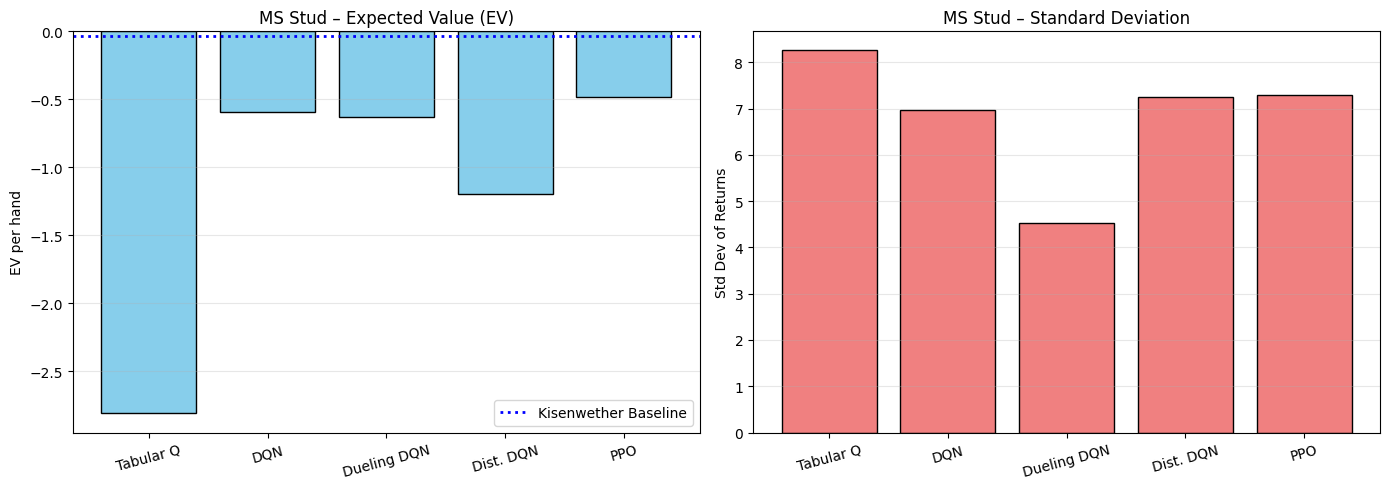

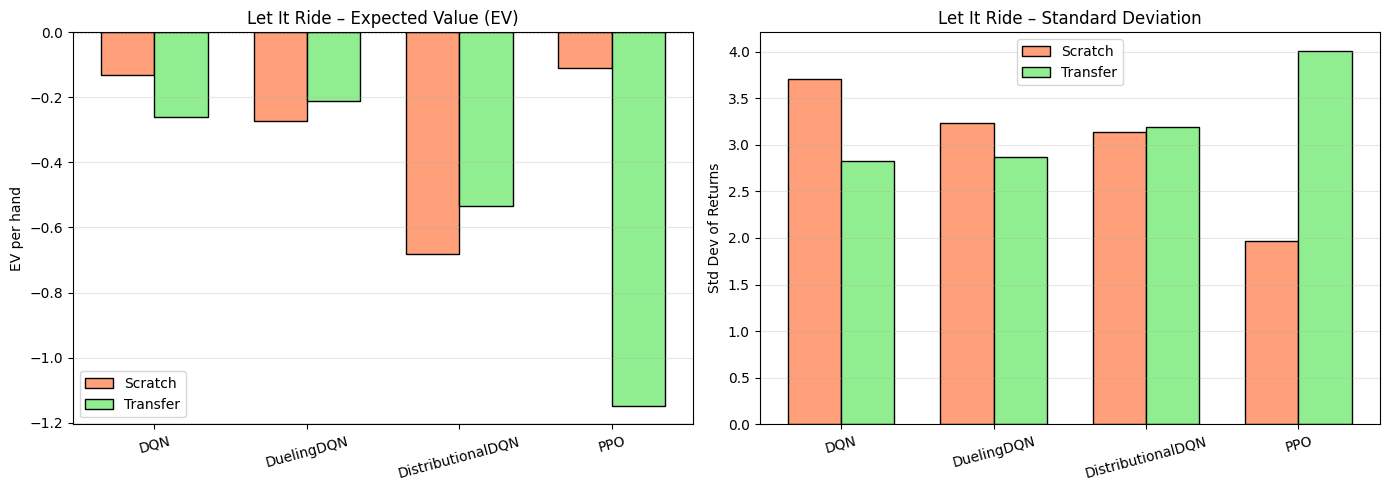

In [67]:
import matplotlib.pyplot as plt


# Load MS results
with open("results_ms.json", "r") as f:
    ms_data = json.load(f)

# Extract data
kisen_ev = ms_data["kisenwether"][0]

model_keys = ["tabular_ms", "dqn_ms", "dueling_ms", "distdqn_ms", "ppo_ms"]
labels = ["Tabular Q", "DQN", "Dueling DQN", "Dist. DQN", "PPO"]

evs  = [ms_data[k][0] for k in model_keys]
stds = [ms_data[k][5] for k in model_keys]

x = np.arange(len(labels))

# --- 1x2 subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# === LEFT: EV subplot ===
axes[0].bar(x, evs, color="skyblue", edgecolor="black")
axes[0].axhline(
    y=kisen_ev, linestyle=":", color="blue", linewidth=2,
    label="Kisenwether Baseline"
)
axes[0].set_title("MS Stud – Expected Value (EV)")
axes[0].set_ylabel("EV per hand")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=15)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend()

# === RIGHT: STD subplot ===
axes[1].bar(x, stds, color="lightcoral", edgecolor="black")
axes[1].set_title("MS Stud – Standard Deviation")
axes[1].set_ylabel("Std Dev of Returns")
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=15)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Load LIR results
with open("results_lir.json", "r") as f:
    lir_data = json.load(f)

agents = ["DQN", "DuelingDQN", "DistributionalDQN", "PPO"]

ev_scratch  = [lir_data[a]["scratch"][0] for a in agents]
ev_transfer = [lir_data[a]["transfer"][0] for a in agents]

std_scratch  = [lir_data[a]["scratch"][5] for a in agents]
std_transfer = [lir_data[a]["transfer"][5] for a in agents]

x = np.arange(len(agents))
width = 0.35

# --- 1x2 subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# === LEFT: EV subplot ===
axes[0].bar(x - width/2, ev_scratch,  width,
            label="Scratch", color="#ffa07a", edgecolor="black")
axes[0].bar(x + width/2, ev_transfer, width,
            label="Transfer", color="#90ee90", edgecolor="black")

axes[0].axhline(y=0.0, linestyle=":", color="black", linewidth=1)
axes[0].set_title("Let It Ride – Expected Value (EV)")
axes[0].set_ylabel("EV per hand")
axes[0].set_xticks(x)
axes[0].set_xticklabels(agents, rotation=15)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# === RIGHT: STD subplot ===
axes[1].bar(x - width/2, std_scratch,  width,
            label="Scratch", color="#ffa07a", edgecolor="black")
axes[1].bar(x + width/2, std_transfer, width,
            label="Transfer", color="#90ee90", edgecolor="black")

axes[1].set_title("Let It Ride – Standard Deviation")
axes[1].set_ylabel("Std Dev of Returns")
axes[1].set_xticks(x)
axes[1].set_xticklabels(agents, rotation=15)
axes[1].grid(axis="y", alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()